<a href="https://colab.research.google.com/github/gapul/ALESS/blob/main/ALESS_YukiKAWASHIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Configuration for manipulating a specific folder
import os
import shutil

# Folder path in Google Drive
google_drive_folder_path = '/content/drive/My Drive/CSVs'  # Change this

# Destination in Colab
colab_folder_path = '/content/CSVs'

# Check if the folder exists in Google Drive
if os.path.exists(google_drive_folder_path):
    # Copy the folder to the Colab environment
    shutil.copytree(google_drive_folder_path, colab_folder_path)
    print(f"Folder copied to: {colab_folder_path}")
else:
    print(f"Folder not found: {google_drive_folder_path}")

# Check the contents of the copied folder
print("Contents of the copied folder:")
print(os.listdir(colab_folder_path))

Mounted at /content/drive
Folder copied to: /content/CSVs
Contents of the copied folder:
['FPL_tweets.csv', 'Bitcoin_tweets.csv', 'fifa_world_cup_2022_tweets.csv', 'IPL_2022_tweets.csv', 'Bitcoin_tweets_dataset_2.csv', 'vaccination_tweets.csv', 'greek_tweets_labeled.csv', 'covidvaccine.csv', 'hashtag_donaldtrump.csv', 'IPL2020_Tweets.csv', 'iphone14-query-tweets.csv', 'FIFA.csv', 'IPL_2021_tweets.csv', 'hashtag_joebiden.csv']


<ipython-input-2-7c30c3d43023>:49: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-2-7c30c3d43023>:49: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-2-7c30c3d43023>:49: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


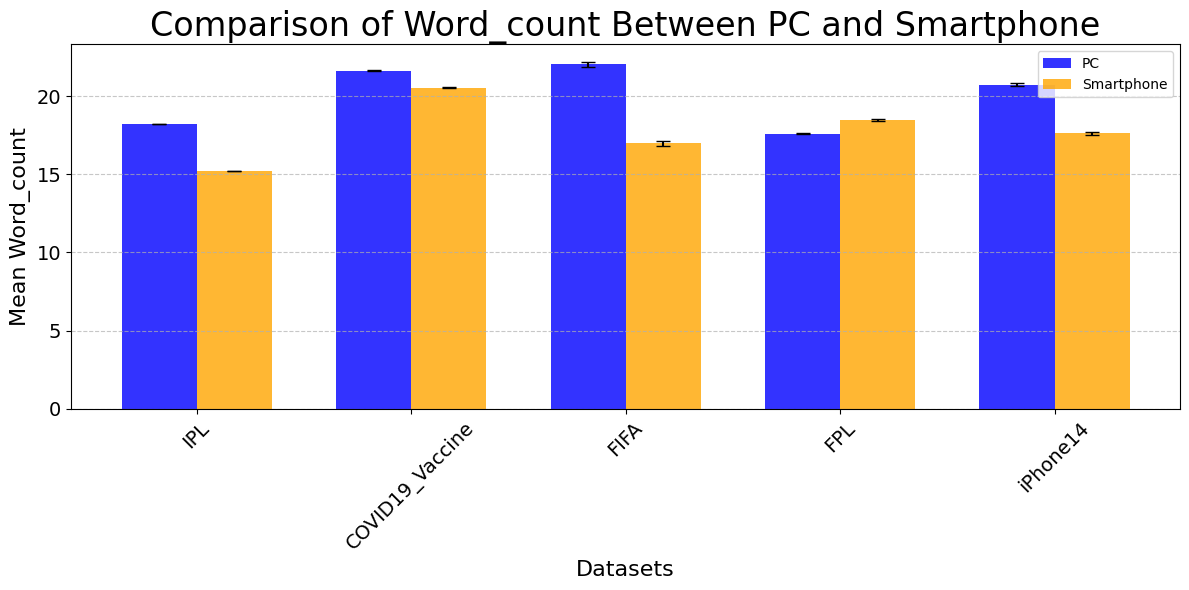


P-values Table:
           Dataset        P-value Significant
0              IPL   0.000000e+00         Yes
1  COVID19_Vaccine  4.722126e-165         Yes
2             FIFA   1.407268e-98         Yes
3              FPL   3.437200e-24         Yes
4         iPhone14  4.085498e-137         Yes




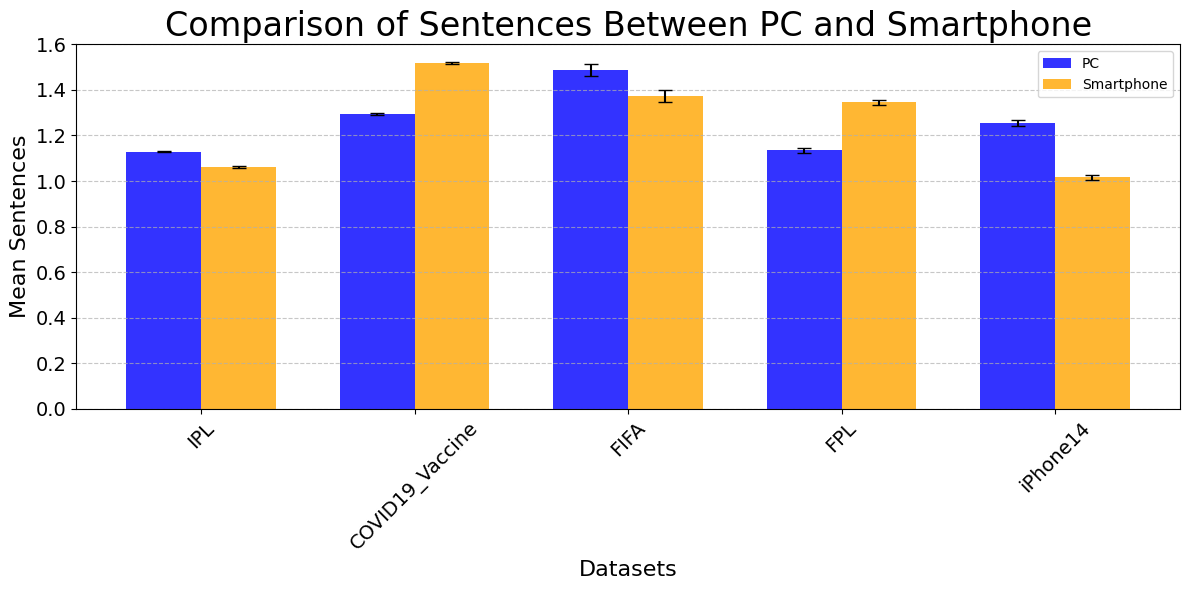


P-values Table:
           Dataset        P-value Significant
0              IPL   1.753806e-50         Yes
1  COVID19_Vaccine  7.332020e-263         Yes
2             FIFA   1.868110e-03         Yes
3              FPL   5.183564e-54         Yes
4         iPhone14   2.276476e-44         Yes




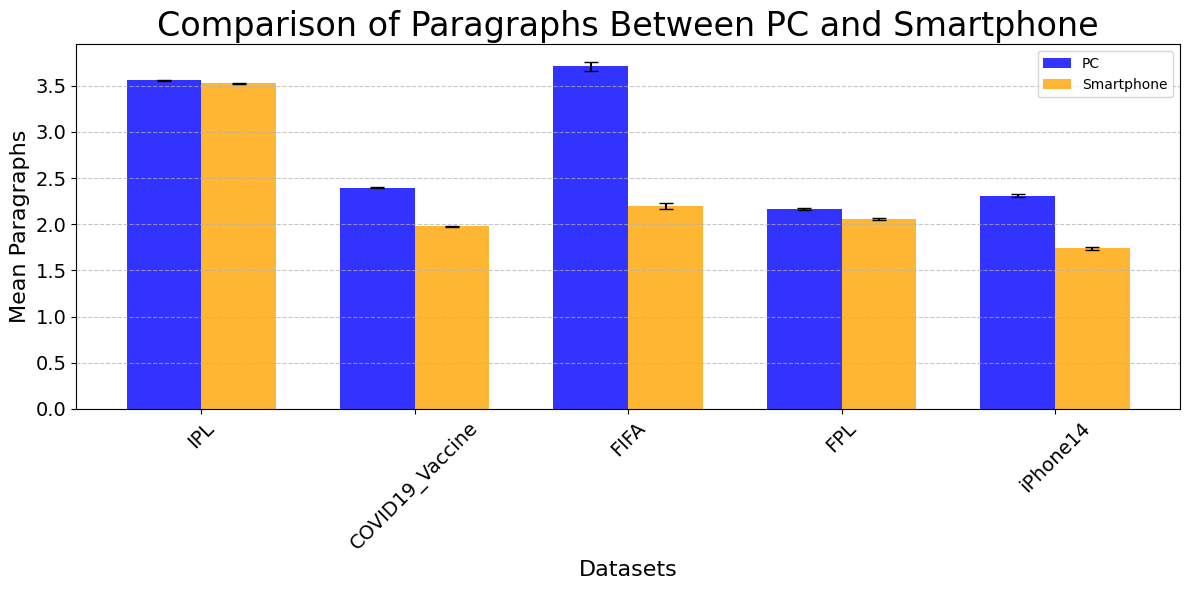


P-values Table:
           Dataset        P-value Significant
0              IPL   7.743469e-07         Yes
1  COVID19_Vaccine   0.000000e+00         Yes
2             FIFA  2.876549e-147         Yes
3              FPL   6.587856e-09         Yes
4         iPhone14  2.926161e-158         Yes




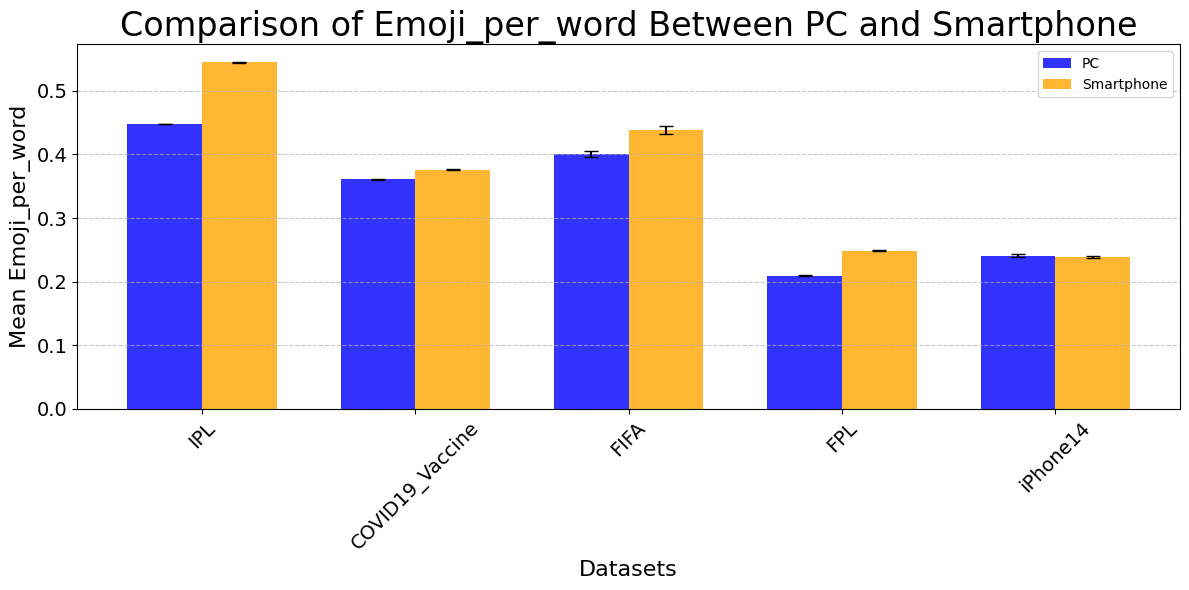


P-values Table:
           Dataset        P-value Significant
0              IPL   0.000000e+00         Yes
1  COVID19_Vaccine   8.670768e-60         Yes
2             FIFA   6.661937e-07         Yes
3              FPL  1.331421e-108         Yes
4         iPhone14   3.160864e-01          No




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from typing import Dict, List

# Constants
DATA_FILE_PATHS: Dict[str, str] = {
    "FIFA": "/content/CSVs/fifa_world_cup_2022_tweets.csv",
    "IPL_2020": "/content/CSVs/IPL2020_Tweets.csv",
    "IPL_2022": "/content/CSVs/IPL_2022_tweets.csv",
    "FPL": "/content/CSVs/FPL_tweets.csv",
    "iPhone14": "/content/CSVs/iphone14-query-tweets.csv",
    "Vaccine": "/content/CSVs/vaccination_tweets.csv",
    "Covid_Vaccine": "/content/CSVs/covidvaccine.csv"
}

SOURCE_MAPPING: Dict[str, List[str]] = {
    "Smartphone": ["Twitter for iPhone", "Twitter for Android", "Twitter Lite"],
    "PC": ["Twitter Web App", "TweetDeck", "Twitter Web Client", "Twitter for Websites"]
}

TWEET_COLS: List[str] = ["Tweet", "text", "tweet_text", "Text"]
SOURCE_COLS: List[str] = ["Source of Tweet", "source", "Source"]

COMBINED_DATASET_NAMES: Dict[str, List[str]] = {
    "IPL": ["IPL_2020", "IPL_2022"],
    "COVID19_Vaccine": ["Vaccine", "Covid_Vaccine"]
}

PLOT_PARAMS: Dict[str, int] = {
    "title_size": 24,
    "label_size": 16,
    "tick_size": 14
}

# Loads and preprocesses multiple CSV files into DataFrames.
def load_and_preprocess_data(file_paths: Dict[str, str]) -> Dict[str, pd.DataFrame]:
    processed_datasets: Dict[str, pd.DataFrame] = {}
    for dataset_name, file_path in file_paths.items():
        processed_datasets[dataset_name] = _process_dataset(file_path)
    return processed_datasets

# Processes a single CSV file.
def _process_dataset(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame()  # Return an empty DataFrame
    except pd.errors.EmptyDataError:
        print(f"Error: File at {file_path} is empty.")
        return pd.DataFrame()
    except pd.errors.ParserError:
        print(f"Error: Parsing error in file at {file_path}.")
        return pd.DataFrame()

    tweet_col = _find_column(df, TWEET_COLS)
    source_col = _find_column(df, SOURCE_COLS)

    if not tweet_col or not source_col:
        raise ValueError("Required columns (Tweet, Source) are missing in the dataset.")

    df = df[[tweet_col, source_col]].rename(columns={tweet_col: "Tweet", source_col: "Source"}).dropna()
    df = _extract_tweet_features(df)
    df = _classify_device(df)

    return df

# Finds the first matching column name in a DataFrame.
def _find_column(df: pd.DataFrame, target_cols: List[str]) -> str | None:
    return next((col for col in df.columns if col in target_cols), None)

# Extracts features from the 'Tweet' column.
def _extract_tweet_features(df: pd.DataFrame) -> pd.DataFrame:
    df["URLs"] = df["Tweet"].apply(lambda x: len(re.findall(r"http[s]?://", x)))
    df["Tweet"] = df["Tweet"].str.replace(r"http[s]?://\S+", "", regex=True)
    df["word_count"] = df["Tweet"].str.split().str.len()
    df["sentences"] = df["Tweet"].apply(lambda x: len(re.split(r"[.!?]", x)) - 1)
    df["paragraphs"] = df["Tweet"].apply(lambda x: x.count("\n") + 1)
    df["emojis"] = df["Tweet"].apply(lambda x: len(re.findall(r"[^\w\s,]", x)))
    df["emoji_per_word"] = df.apply(
        lambda x: x["emojis"] / x["word_count"] if x["word_count"] > 0 else 0, axis=1
    )
    return df

# Classifies the device based on the 'Source' column.
def _classify_device(df: pd.DataFrame) -> pd.DataFrame:
    df["Device"] = df["Source"].apply(_map_source)
    return df.dropna(subset=["Device"])

# Maps a source string to a device category.
def _map_source(source: str) -> str | None:
    for category, keywords in SOURCE_MAPPING.items():
        if any(keyword in source for keyword in keywords):
            return category
    return None

# Combines specified datasets.
def combine_datasets(
    processed_datasets: Dict[str, pd.DataFrame], combined_dataset_names: Dict[str, List[str]]
) -> Dict[str, pd.DataFrame]:
    combined_datasets: Dict[str, pd.DataFrame] = {}
    for combined_name, dataset_names in combined_dataset_names.items():
        combined_datasets[combined_name] = pd.concat(
            [processed_datasets.get(name, pd.DataFrame()) for name in dataset_names],
            ignore_index=True,
        )
    # Add datasets that do not need to be combined directly
    for dataset_name, df in processed_datasets.items():
        if dataset_name not in [
            item for sublist in combined_dataset_names.values() for item in sublist
        ]:
            combined_datasets[dataset_name] = df

    return combined_datasets

# Samples the combined datasets to balance PC and Smartphone data.
def sample_datasets(
    combined_datasets: Dict[str, pd.DataFrame], random_state: int = 42
) -> Dict[str, pd.DataFrame]:
    sampled_datasets: Dict[str, pd.DataFrame] = {}
    for dataset_name, df in combined_datasets.items():
        pc_df = df[df["Device"] == "PC"]
        smartphone_df = df[df["Device"] == "Smartphone"]
        min_size = min(len(pc_df), len(smartphone_df))

        sampled_pc = pc_df.sample(n=min_size, random_state=random_state)
        sampled_smartphone = smartphone_df.sample(n=min_size, random_state=random_state)

        sampled_datasets[dataset_name] = pd.concat([sampled_pc, sampled_smartphone])
    return sampled_datasets

# Plots a grouped bar chart comparing means and standard deviations.
def plot_grouped_bar_chart(
    data_dict: Dict[str, pd.DataFrame],
    value_col: str,
    group_col: str = "Device",
    title_size: int = 16,
    label_size: int = 14,
    tick_size: int = 12,
    figsize: tuple[int, int] = (12, 6)
) -> None:
    datasets = list(data_dict.keys())
    means_pc: List[float] = []
    stds_pc: List[float] = []
    means_smartphone: List[float] = []
    stds_smartphone: List[float] = []
    p_values: List[float] = []
    significant: List[str] = []

    for dataset_name, df in data_dict.items():
        pc_data = df[df[group_col] == "PC"][value_col]
        smartphone_data = df[df[group_col] == "Smartphone"][value_col]

        means_pc.append(pc_data.mean())
        stds_pc.append(pc_data.std() / np.sqrt(len(pc_data)))
        means_smartphone.append(smartphone_data.mean())
        stds_smartphone.append(smartphone_data.std() / np.sqrt(len(smartphone_data)))

        t_stat, p_value = stats.ttest_ind(pc_data, smartphone_data)
        p_values.append(p_value)
        significant.append("Yes" if p_value <= 0.05 else "No")

    x = np.arange(len(datasets))
    width = 0.35

    plt.figure(figsize=figsize)
    plt.bar(
        x - width / 2,
        means_pc,
        width,
        yerr=stds_pc,
        label="PC",
        capsize=5,
        color="blue",
        alpha=0.8,
    )
    plt.bar(
        x + width / 2,
        means_smartphone,
        width,
        yerr=stds_smartphone,
        label="Smartphone",
        capsize=5,
        color="orange",
        alpha=0.8,
    )

    plt.xticks(x, datasets, rotation=45, fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.title(
        f"Comparison of {value_col.capitalize()} Between PC and Smartphone",
        fontsize=title_size,
    )
    plt.ylabel(f"Mean {value_col.capitalize()}", fontsize=label_size)
    plt.xlabel("Datasets", fontsize=label_size)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    p_value_table = pd.DataFrame({"Dataset": datasets, "P-value": p_values, "Significant": significant})
    print("\nP-values Table:")
    print(p_value_table)
    print("\n")

# Main function to run the analysis.
def main():
    processed_datasets = load_and_preprocess_data(DATA_FILE_PATHS)
    combined_datasets = combine_datasets(processed_datasets, COMBINED_DATASET_NAMES)
    sampled_datasets = sample_datasets(combined_datasets)

    for col in ["word_count", "sentences", "paragraphs", "emoji_per_word"]:
        plot_grouped_bar_chart(sampled_datasets, col, **PLOT_PARAMS)


if __name__ == "__main__":
    main()